In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from wordcloud import WordCloud 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.
##      ignore warnings
import warnings
warnings.filterwarnings('ignore')
### Random Forest
from sklearn.ensemble import RandomForestClassifier
### cross validation
from sklearn.model_selection import cross_val_score
#### confusion matrix
from sklearn.metrics import confusion_matrix
### classification report
from sklearn.metrics import classification_report
### accuracy score
from sklearn.metrics import accuracy_score


In [66]:
import easygui

In [67]:
path = easygui.fileopenbox()

In [68]:
path

'/Users/giridharana.r/Desktop/S Assignments/DATA 245 - Machine  learning /Project/Tripadvisor_Reviews/CSV/tripadvisor_hotel_reviews.csv'

In [69]:
df = pd.read_csv(path)

In [70]:
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2
2,"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept, got room night no, 1st drop desk, called maintainence came look thermostat told play settings happy digital box wo n't work, asked wakeup 10am morning did n't happen, called later 6pm nap wakeup forgot, 10am wakeup morning yep forgotten.the bathroom facilities great room surprised room sold whirlpool bath tub n't bath amenities, great relax water jets going,",3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy, goldfish n

### EDA

In [71]:
df.shape

(20491, 2)

There are 20491 reviews and 2 columns such as Review and Rating 

In [72]:
df["Rating"].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Five types of Ratings from 1 - 5 with 1 being the lowest and 5 being the highest

In [73]:
px.histogram(df,x = "Rating",color = "Rating",title = "Hotel Ratings", width=600,height=600)

There are more number of positive reviews than negative reviews on seeing the plot

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Review is in the object format and Rating is in int format

#### Checking the missing values

In [75]:
def missing(df):
    missing_value = df.isnull().sum().sort_values(ascending=False)
    missing_percentage = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    total_missing = pd.concat([missing_value,missing_percentage],axis=1,keys=["Total Missing","Percentage"])
    
    return total_missing
    

In [76]:
missing(df)

,Total Missing,Percentage
Review,0,0.0
Rating,0,0.0


There are no missing values present in the dataset and all the data are labelled

In [77]:
#### Checking for empty strings

df.loc[df["Review"] == ""]

,Review,Rating


There are no empty strings present

#### Word Cloud of all reviews

In [78]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

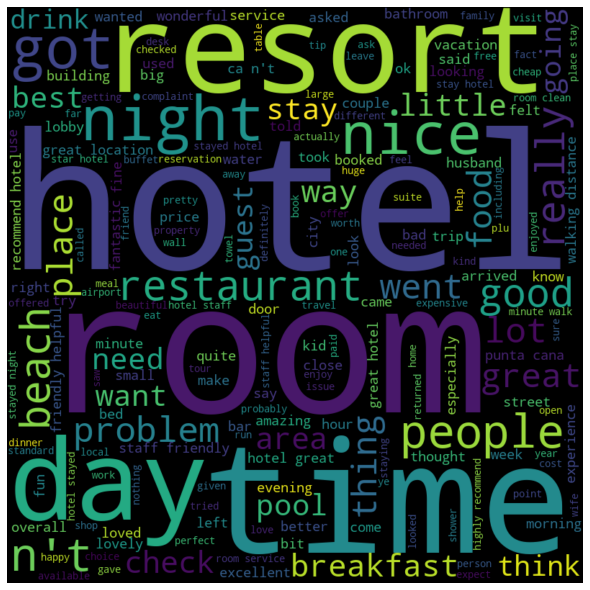

In [79]:
wordCloud_generator(df['Review'])

#### Word count of ratings


In [80]:
df['Word Count'] = df['Review'].apply(lambda x: len(str(x).split(" ")))

In [81]:
df.head()

,Review,Rating,Word Count
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,",4,89
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2,252
2,"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept, got room night no, 1st drop desk, called maintainence came look thermostat told play settings happy digital box wo n't work, asked wakeup 10am morning did n't happen, called later 6pm nap wakeup forgot, 10am wakeup morning yep forgotten.the bathroom facilities great room surprised room sold whirlpool bath tub n't bath amenities, great relax water jets going,",3,219
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch

<AxesSubplot:xlabel='Rating', ylabel='Word Count'>

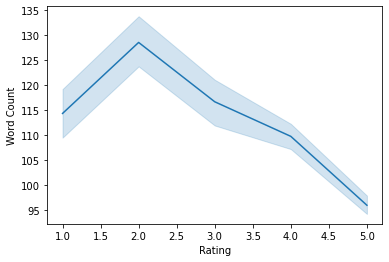

In [82]:
sns.lineplot(x="Rating", y="Word Count", data=df)

### Modelling

In [83]:
df["Rating"].value_counts()


5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Since there are lots of reviews we can introduce a new column in  which we can take ratings of 4,5 as positive, 3 as neutral and 1,2 as negative. 

In [84]:
df_negative = df.loc[df["Rating"] < 3]
df_negative = df_negative.reset_index(drop=True)

In [85]:
print(len(df_negative))

3214


In [86]:
df_five = df.loc[df["Rating"] == 5]
df_five = df_five.reset_index(drop=True)

In [87]:
print(len(df_five))

9054


In [88]:
df_positive = df_five[:len(df_negative)]


In [89]:
print(len(df_positive))

3214


In [90]:
df_all = pd.concat([df_negative,df_positive],axis=0)


In [91]:
df_all = df_all.reset_index(drop=True)

In [92]:
len(df_all)

6428

In [93]:
df_all.head()

,Review,Rating,Word Count
0,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2,252
1,"poor value stayed monaco seattle july, nice hotel priced 100- 150 night not, hotel takes beating quotient, experience simply average, nothing exceptional paying 300+ n't ca n't terribly disappointed, wife stayed nicest suites 200/night felt like overpaying, best advice shop, quality-wise league average marriott nice best western,",2,49
2,"horrible customer service hotel stay february 3rd 4th 2007my friend picked hotel monaco appealing website online package included champagne late checkout 3 free valet gift spa weekend, friend checked room hours earlier came later, pulled valet young man just stood, asked valet open said, pull bags didn__Ç_é_ offer help, got garment bag suitcase came car key room number says not valet, car park car street pull, left key working asked valet park car gets, went room fine bottle champagne oil lotion gift spa, dressed went came got bed noticed blood drops pillows sheets pillows, disgusted just unbelievable, called desk sent somebody 20 minutes later, swapped sheets left apologizing, sunday morning called desk speak management sheets aggravated rude, apparently no manager kind supervisor weekend wait monday morning, young man spoke said cover food adding person changed sheets said fresh blood rude tone, checkout 3pm package booked, 12 1:30 staff maids tried walk room opening door apologizing closing, people called saying check 12 remind package, finally packed things went downstairs check, quickly signed paper took, way took closer look room, unfortunately covered food offered charged valet, called desk ask charges lady answered snapped saying aware problem experienced monday like told earlier, life treated like hotel, not sure hotel constantly problems lucky ones stay recommend anybody know,",1,216
3,"disappointed say anticipating stay hotel monaco based reviews seen tripadvisor, definitely disppointment, decor room hotel envisioned nice, housekeeping staff impressive extremely polite cheery helpful, desk bellmen standard customer service, lots little things easily overlooked broken make mirror sagging post bathroom jiggly entrance handle room did n't feel secure handle nearly falling door, husband early morning flight mid-week asked cab called, suggested cab ride cost double private car flat-rate n't ca

In [94]:
df_all["Rating"].value_counts()

5    3214
2    1793
1    1421
Name: Rating, dtype: int64

#### Creating a sentiments column

In [95]:
df_all["Sentiment"]  = np.where(df_all["Rating"] == 5, "Positive", "Negative")

In [96]:
df_all.tail()

,Review,Rating,Word Count,Sentiment
6423,"really cozy place enjoyed stay, just came short stay library hotel, picked hotel remembered spent lovely evening roof terrace year ago, reading reviews curious rest hotel.everybody desk helpful friendly did swift check-in, lobby understated minimalist book shelves look booked junior suit special discount price 499 new york substantial money expected lot.i not disappointed, room looked exactly like picture website, lot room wasted room/hallway spacious airy lot windows, nice wooden blinds gave room warm feeling did room colours beige dark wood, small sofa corner armchairs large flat screen tv, bathroom spacious nicely decorated amenities needs.having lived new york knew not going quietest streets mid-town, definitely noisy windows sound-proof.i did not reading room spent time upstairs winter garden course roof terrace, nice rooftop terrace comfortable furniture, benches little stools quite uncomfortable impossible spent leisure afternoon sun major backache, free hotspot available terrace able emails sitting sun not hotels ny offer travellers said great place worth money return,",5,157,Positive
6424,"perfect hotel hotel does not really need glowing review nice add, stayed great attention, room lovely public areas beautiful especially bar 14th floor staff not nicer, petite room reviews n't normal sized double room, suppose does small american room normally queen beds just normal double room, not occurred think room size not described petite room, stayed husband nights fine,",5,61,Positive
6425,"perfect hotel small hotel comfortable perfect location helpful staff good, visit new york come love room no doubt,",5,20,Positive
6426,"ordinary location extraordinary hotel know lovely boutique hotel got positive reviews, stayed based tripadvisor reviews pleased, night stay nov 16 room, small perfect person small suitcase, design dÄcor space furnishings simple elegant line, room didn__Ç_é_ feel cramped small person, room windows good lighting__Ç_ecessary want try interesting books shelf, room bath spotlessly clean, room 11th floor little street noise heard, there__Ç_é_ no room service complimentary food beverages available day long second floor continental breakfast morning coffee tea cookies afternoon wine cheese early evening, hotel staff highly professional friendly helpful address just ask, 41st madison address isn__Ç_é_ trendy nyc areas hotel definitely worth stay, i__Ç_éêl going january reserved room,",5,109,Positive
6427,"classy indulgence awesome experience, staff n't chocolates left day complimentary bottles water, travelling south america just little bit pampering needed perfectly located close, nice end town midtown believe used lingo, food really great, really exceptional cheeses husband said wine pretty great, perfect snacks lunch dinner, just loved place, bought mug remember time, thank staff making ny trip remember, just aware prices upper end ny hotels expensive not classy,",5,70,Positive


#### Randomizing the data


In [97]:
df_all = df_all.sample(frac=1)
df_all = df_all.reset_index(drop=True)

In [98]:
df_all.tail()

,Review,Rating,Word Count,Sentiment
6423,"rip, self husband just returned honeymoon evening n't wait let know terrible place secrets excellence, arrived noticed cockroaches surrounding minibar called rep excellence club going send spray night cockroaches room night 1 sitting husband toothbrush, called sending immediately 45 minutes later tell people just pay attention problem, switched room ended room double beds love lucy, sick majority trip going bano minutes make matters worse toliet did n't flush waiting people fix, waste 5 thousand dollars, vip excellence club crap food serve sitting day god knows waht crawling, good thing secrets met really nice people,",1,96,Negative
6424,"tripasaurus rex wife daughter longstanding tradition visiting san francisco days shopping theater eating holiday pleasure just christmas, live 35 miles city quite familiar hotels restaurants, tradition large suite bigger union street hotels hyatt st. francis cliff, year decided stay rex smaller euro-style french owned hotel arts/literature spin, not algonquin nyc venerable literarti haunt wow, great place, location perfect sight street act theater, valet parking reasonable efficient san francisco room cool, daughter college student gasped entering declared soooo like place stayed bologna cool correct ambiance significant price difference bologna room rate 4-times cost rex, rex equalled terms sophisticated magazines literature chic art work decor color schemes, staff attentive room service prompt food including onsite cafe andre terrific place dine grand, complimentary wine/apertif hour 5-6, sat library comfortable room fireplace books lots friendly guests, guests european chatted austrian woman french gentleman glass cabernet, time departed theater group expanded 7 exchanging email addresses, n't expect amenities health club jacuzzi, rex, bud expect experience charm classic european 3/4-star, unless wed hiltons holiday inns hyatts howard johnsons love quaint sophisticated hotel br,",5,179,Positive
6425,"rated not worth money disappointment, deluxe harbour view room 21st floor, walked room walked straight n't view, rooms no character need refurbishment, admit bathroom fantastic, apart helpful conceirge staff rude unfriendly, felt like supposed greatful stay.the pool area lovely day advatnage unable sit sun terrace 2.30pm preparing evening function.the japenese restuarant good felix, avoid felix bar extremely cramped.my recommendation visit hotel afternoon tea wonder round n't waste money stay,",1,71,Negative
6426,"paradise oasis desert moment pulled grounds hotel blown away size resort, soon stepped towncar took airport greeted wonderful resort staff welcomed phoenix, bell staff took luggage room way telling area not phoenix, planned trip grand canyon told best way, standard room nice 2 people, beautiful bathrooms norm, bed confortable easy fall asleep, nice view grounds balcony nice just sit enjoy weather ambient sounds resort, hotel restaurants great food notch, highly recommend butterfish roy salmon dish italian place forgot, main pool area lot different pools experience nice place really, waterfalls tons desert flowers cacti look, plenty chairs available area not overly crowded, weekend place sit afternoon, sit staff come food drink order eat right pool, lazy river great hot sun relax hours end just floating aournd, waterslide kids, saw different types people families welcome kids not problem, 2 fitness centers pay 10 includes spa services free used better average hotel gym, 8 new treadmills ellipitcals free weight area bikes, better weight machines pay gym, golf courses maintained challenging, not play golf nicest courses played, 2 played faldo, car rental place hotel rent car like did drive grand canyon places, group people paid stay hotel not sure not afford 300 plus night, bit pricy worth trip, nicest resorts stayed, small problem lot birds flying, just watch food not start picking,",5,220,Positive
6427,"loved hotel read reviews hotel n't quite

### Data preprocessing

In [99]:
df_all.shape

(6428, 4)

In [100]:
df_new = df_all[['Review','Sentiment']]

In [101]:
df_new.head(5)

,Review,Sentiment
0,"fantastic florence visited hotel savoy second time years, return visit met exceeded fond memories fantastic florentine hotel.the common spaces hotel contemporary comfortable, restaurant seating spills piazza best food seating square, rooms designed sophisticated not fussy dÄcor rich mosaic-ed bathrooms, important staff extremely cordial accommodating, utilized concierge evening consistently recommended interesting restaurants, arranged tours local museums e.g, cezanne florence exhibit, departure staff members asked returning savoy.__Ç answered soon br/,",Positive
1,"travel agent review travel dominican republic regardless stay need understand area not tourist attraction long, working things, language barrier foreigner, customer service not ideal, going town not good idea, not perfect beautiful area way, exception melia, n't waste money time, not send clients melia unless begged, plenty great resorts area price, seen rude staff, people trying sell items beach pleasant staff ran, bad review read true, food joke, reservation, tell room did n't used, balcony door not open mainteance came fix, walking room time walk door, n't know, 2 day safe kept getting robbed apparently, need pay money things, mold ceiling, maid did n't, reason took clothing dirty towels, did, impression checked served champagne person counter look eye smiled busy talking counter person course checking, things good property beach pool, pool great suprisingly clean, beach not clean good walking sand soft,",Negative
2,"not grand, depended tripadvisor reviews booked hotel wife, reviews ecstatic positive perfect hotel trip barcelona, experience pretty far perfect, feel need write review balance glowing reviews hotel receiving fair warning fellow travelers depend love tripadvisor.in nights stayed gran hotel torre catalunya poor overall experience.firstly standard rooms average, barely 4 stars standard room dark stuffy pretty grim, close train/subway station hotel location felt far barcelona cultural attractions, prepared five-seven minute walk station plus 15-20 minute ride major attraction, prior day hotel covered just bit staff members fine, not overly helpful friendly service provided met did not exceed expectations prices paid.our trip happened coincide holy week 2008 day good friday pretty major holiday barcelona, not knowing sites limited hours good friday planned early start day, asked hotel 7:30 wake friday morning, received no, instead bellhop knocked door 9:40 wake, explained sent no answer room 7:30, thought definitely did not miss 7:30 phones extra loud, second thought supposed receive 7:30 bellhop standing door 9:40, not wanting messenger thanked bellhop told taking hotel management.at lobby explained situation manager charge, initially dubious story believing really did miss 7:30am, persisted eventually called person responsible wake calls, admitted explained simply forgot, needless explain frustrating situation having lost good hours day barcelona.to make issue manager offered upgrade room night, did follow gesture appreciative, ca n't help feel let-down overall experience gran hotel torre catalunya,",Negative
3,"honest review husband just got iberostar dominicana punta cana domincan republic not used, usually adults resorts great deal domincan decided, 3 iberostar properties domicana punta cana bavaro, domincana punta cana really property, exchange privledges punta cana not bavaro, low good bad, experienced travelers review perspective 30 couple no children usually stay adult resorts.there no swim pool bar use stay dominicana punta cana, swim pool bar bavaro people staying property use, not serve food drinks, try tipping wo n't, use wristband band different color obvious n't staying bavaro, huge bummer sat pool bar know coming, nice thing, problem finding spot beach, people 5am towels chairs reserve clearly states not reserve seats, not open hut venture 7am, husband went 7am breakfast saw chairs not marked towels stuff went wate

In [102]:
df_new.shape

(6428, 2)

In [103]:
### stripping html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

### expanding the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)
#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text
def clean_text(text):
    text = replace_contractions(text)
    text = strip_html_tags(text)
    text = remove_numbers(text)
    return text


In [104]:
#### applying in the dataframe
df_new['Review'] = df_new['Review'].apply(lambda x: clean_text(x))

In [105]:
df_new.head(5)

,Review,Sentiment
0,"fantastic florence visited hotel savoy second time years, return visit met exceeded fond memories fantastic florentine hotel.the common spaces hotel contemporary comfortable, restaurant seating spills piazza best food seating square, rooms designed sophisticated not fussy dÄcor rich mosaic-ed bathrooms, important staff extremely cordial accommodating, utilized concierge evening consistently recommended interesting restaurants, arranged tours local museums e.g, cezanne florence exhibit, departure staff members asked returning savoy.__Ç answered soon br/,",Positive
1,"travel agent review travel dominican republic regardless stay need understand area not tourist attraction long, working things, language barrier foreigner, customer service not ideal, going town not good idea, not perfect beautiful area way, exception melia, n't waste money time, not send clients melia unless begged, plenty great resorts area price, seen rude staff, people trying sell items beach pleasant staff ran, bad review read true, food joke, reservation, tell room did n't used, balcony door not open mainteance came fix, walking room time walk door, n't know, day safe kept getting robbed apparently, need pay money things, mold ceiling, maid did n't, reason took clothing dirty towels, did, impression checked served champagne person counter look eye smiled busy talking counter person course checking, things good property beach pool, pool great suprisingly clean, beach not clean good walking sand soft,",Negative
2,"not grand, depended tripadvisor reviews booked hotel wife, reviews ecstatic positive perfect hotel trip barcelona, experience pretty far perfect, feel need write review balance glowing reviews hotel receiving fair warning fellow travelers depend love tripadvisor.in nights stayed gran hotel torre catalunya poor overall experience.firstly standard rooms average, barely stars standard room dark stuffy pretty grim, close train/subway station hotel location felt far barcelona cultural attractions, prepared five-seven minute walk station plus - minute ride major attraction, prior day hotel covered just bit staff members fine, not overly helpful friendly service provided met did not exceed expectations prices paid.our trip happened coincide holy week day good friday pretty major holiday barcelona, not knowing sites limited hours good friday planned early start day, asked hotel : wake friday morning, received no, instead bellhop knocked door : wake, explained sent no answer room :, thought definitely did not miss : phones extra loud, second thought supposed receive : bellhop standing door :, not wanting messenger thanked bellhop told taking hotel management.at lobby explained situation manager charge, initially dubious story believing really did miss :am, persisted eventually called person responsible wake calls, admitted explained simply forgot, needless explain frustrating situation having lost good hours day barcelona.to make issue manager offered upgrade room night, did follow gesture appreciative, ca n't help feel let-down overall experience gran hotel torre catalunya,",Negative
3,"honest review husband just got iberostar dominicana punta cana domincan republic not used, usually adults resorts great deal domincan decided, iberostar properties domicana punta cana bavaro, domincana punta cana really property, exchange privledges punta cana not bavaro, low good bad, experienced travelers review perspective couple no children usually stay adult resorts.there no swim pool bar use stay dominicana punta cana, swim pool bar bavaro people staying property use, not serve food drinks, try tipping wo n't, use wristband band different color obvious n't staying bavaro, huge bummer sat pool bar know coming, nice thing, problem finding spot beach, people am towels chairs reserve clearly states not reserve seats, not open hut venture am, husband went am breakfast saw chairs not marked towels stuff went water chairs hut, am woman approached said hut

#### Tokenizing the reviews


In [106]:
df_new['Review'] = df_new.apply(lambda x: nltk.word_tokenize(x['Review']), axis=1)

In [107]:
df_new.head(5)

,Review,Sentiment
0,"[fantastic, florence, visited, hotel, savoy, second, time, years, ,, return, visit, met, exceeded, fond, memories, fantastic, florentine, hotel.the, common, spaces, hotel, contemporary, comfortable, ,, restaurant, seating, spills, piazza, best, food, seating, square, ,, rooms, designed, sophisticated, not, fussy, dÄcor, rich, mosaic-ed, bathrooms, ,, important, staff, extremely, cordial, accommodating, ,, utilized, concierge, evening, consistently, recommended, interesting, restaurants, ,, arranged, tours, local, museums, e.g, ,, cezanne, florence, exhibit, ,, departure, staff, members, asked, returning, savoy.__Ç, answered, soon, br/, ,]",Positive
1,"[travel, agent, review, travel, dominican, republic, regardless, stay, need, understand, area, not, tourist, attraction, long, ,, working, things, ,, language, barrier, foreigner, ,, customer, service, not, ideal, ,, going, town, not, good, idea, ,, not, perfect, beautiful, area, way, ,, exception, melia, ,, n't, waste, money, time, ,, not, send, clients, melia, unless, begged, ,, plenty, great, resorts, area, price, ,, seen, rude, staff, ,, people, trying, sell, items, beach, pleasant, staff, ran, ,, bad, review, read, true, ,, food, joke, ,, reservation, ,, tell, room, did, n't, used, ,, balcony, door, not, open, mainteance, came, fix, ,, walking, room, ...]",Negative
2,"[not, grand, ,, depended, tripadvisor, reviews, booked, hotel, wife, ,, reviews, ecstatic, positive, perfect, hotel, trip, barcelona, ,, experience, pretty, far, perfect, ,, feel, need, write, review, balance, glowing, reviews, hotel, receiving, fair, warning, fellow, travelers, depend, love, tripadvisor.in, nights, stayed, gran, hotel, torre, catalunya, poor, overall, experience.firstly, standard, rooms, average, ,, barely, stars, standard, room, dark, stuffy, pretty, grim, ,, close, train/subway, station, hotel, location, felt, far, barcelona, cultural, attractions, ,, prepared, five-seven, minute, walk, station, plus, -, minute, ride, major, attraction, ,, prior, day, hotel, covered, just, bit, staff, members, fine, ,, not, overly, helpful, friendly, service, provided, ...]",Negative
3,"[honest, review, husband, just, got, iberostar, dominicana, punta, cana, domincan, republic, not, used, ,, usually, adults, resorts, great, deal, domincan, decided, ,, iberostar, properties, domicana, punta, cana, bavaro, ,, domincana, punta, cana, really, property, ,, exchange, privledges, punta, cana, not, bavaro, ,, low, good, bad, ,, experienced, travelers, review, perspective, couple, no, children, usually, stay, adult, resorts.there, no, swim, pool, bar, use, stay, dominicana, punta, cana, ,, swim, pool, bar, bavaro, people, staying, property, use, ,, not, serve, food, drinks, ,, try, tipping, wo, n't, ,, use, wristband, band, different, color, obvious, n't, staying, bavaro, ,, huge, bummer, sat, pool, ...]",Negative
4,"[worst, serviced, ,, star__Ç, hotel, hong, kong, thanks, letting, express, disappointment, disgracefulness, so-called, star__Ç, hotel, hong, kong, island, shangri-la, hotel, ,, just, contractor, client, company, rented, hotel__Ç_é_, ballroom, function, not, imagine, deserve, kind, service, attitude, people, hotel.we, hired, client, work, providing, av, services, function, island, shangri-la, today, ,, event, ended, .p.m, ., packed, equipment, till, .p.m, ,, soon, stuff, packed, went, banquet, office, form, leave, building, ,, office, /f, ran, security, office, /f, help, ,, told, security, office, banquet, office, place, issue, form, ,, hopelessly, ran, banquet, office, try, luck, ,, unfortunately, room, ,, ran, ballroom, seek, help, ,, hotel, ...]",Negative


#### Removing stop words and lemmatization

In [108]:
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

### removing the non ascii characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

### converting all the words to lower case
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

### removing the punctuations
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#### removing the stopwords
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def stop_lemma(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join (words)





In [109]:
df_new['Review'] = df_new.apply(lambda x: stop_lemma(x['Review']),axis=1)

In [110]:
df_new.head(5)

,Review,Sentiment
0,fantastic florence visit hotel savoy second time years return visit meet exceed fond memories fantastic florentine hotelthe common space hotel contemporary comfortable restaurant seat spill piazza best food seat square room design sophisticate fussy dacor rich mosaiced bathrooms important staff extremely cordial accommodate utilize concierge even consistently recommend interest restaurants arrange tour local museums eg cezanne florence exhibit departure staff members ask return savoy__c answer soon br,Positive
1,travel agent review travel dominican republic regardless stay need understand area tourist attraction long work things language barrier foreigner customer service ideal go town good idea perfect beautiful area way exception melia nt waste money time send clients melia unless beg plenty great resort area price see rude staff people try sell items beach pleasant staff run bad review read true food joke reservation tell room nt use balcony door open mainteance come fix walk room time walk door nt know day safe keep get rob apparently need pay money things mold ceiling maid nt reason take clothe dirty towel impression check serve champagne person counter look eye smile busy talk counter person course check things good property beach pool pool great suprisingly clean beach clean good walk sand soft,Negative
2,grand depend tripadvisor review book hotel wife review ecstatic positive perfect hotel trip barcelona experience pretty far perfect feel need write review balance glow review hotel receive fair warn fellow travelers depend love tripadvisorin nights stay gran hotel torre catalunya poor overall experiencefirstly standard room average barely star standard room dark stuffy pretty grim close trainsubway station hotel location felt far barcelona cultural attractions prepare fiveseven minute walk station plus minute ride major attraction prior day hotel cover bite staff members fine overly helpful friendly service provide meet exceed expectations price paidour trip happen coincide holy week day good friday pretty major holiday barcelona know sit limit hours good friday plan early start day ask hotel wake friday morning receive instead bellhop knock door wake explain send answer room think definitely miss phone extra loud second think suppose receive bellhop stand door want messenger thank bellhop tell take hotel managementat lobby explain situation manager charge initially dubious story believe really miss persist eventually call person responsible wake call admit explain simply forget needle explain frustrate situation lose good hours day barcelonato make issue manager offer upgrade room night follow gesture appreciative ca nt help feel letdown overall experience gran hotel torre catalunya,Negative
3,honest review husband get iberostar dominicana punta cana domincan republic use usually adults resort great deal domincan decide iberostar properties domicana punta cana bavaro domincana punta cana really property exchange privledges punta cana bavaro low good bad experience travelers review perspective couple children usually stay adult resortsthere swim pool bar use stay dominicana punta cana swim pool bar bavaro people stay property use serve food drink try tip wo nt use wristband band different color obvious nt stay bavaro huge bummer sit pool bar know come nice thing problem find spot beach people towel chair reserve clearly state reserve seat open hut venture husband go breakfast saw chair mark towel stuff go water chair hut woman approach say hut reserve towel tell leave towel chair mark take say towel hut tell ca nt reserve huts say come morning mark try politely tell reserve say go eat breakfast question take hours eat breakfast say hut say share leave seat open tell problem security know nt walk away leave towel use seat hour sand invite people look spot tell ya beach area seat accomodate guests people butt crack dawn mark spot people dominicana punta cana iberostars huge problem forewarnedthe pool 

The above data has been cleaned and preprocessed and we can now start building our model.

#### Preparing model using CountVectorizer and Tfidf

In [114]:
replaceStruct = {
                "Sentiment": {"Positive": 1, "Negative": 0}
                }

In [115]:
df_new = df_new.replace(replaceStruct)

In [116]:
df_new.head(5)

,Review,Sentiment
0,fantastic florence visit hotel savoy second time years return visit meet exceed fond memories fantastic florentine hotelthe common space hotel contemporary comfortable restaurant seat spill piazza best food seat square room design sophisticate fussy dacor rich mosaiced bathrooms important staff extremely cordial accommodate utilize concierge even consistently recommend interest restaurants arrange tour local museums eg cezanne florence exhibit departure staff members ask return savoy__c answer soon br,1
1,travel agent review travel dominican republic regardless stay need understand area tourist attraction long work things language barrier foreigner customer service ideal go town good idea perfect beautiful area way exception melia nt waste money time send clients melia unless beg plenty great resort area price see rude staff people try sell items beach pleasant staff run bad review read true food joke reservation tell room nt use balcony door open mainteance come fix walk room time walk door nt know day safe keep get rob apparently need pay money things mold ceiling maid nt reason take clothe dirty towel impression check serve champagne person counter look eye smile busy talk counter person course check things good property beach pool pool great suprisingly clean beach clean good walk sand soft,0
2,grand depend tripadvisor review book hotel wife review ecstatic positive perfect hotel trip barcelona experience pretty far perfect feel need write review balance glow review hotel receive fair warn fellow travelers depend love tripadvisorin nights stay gran hotel torre catalunya poor overall experiencefirstly standard room average barely star standard room dark stuffy pretty grim close trainsubway station hotel location felt far barcelona cultural attractions prepare fiveseven minute walk station plus minute ride major attraction prior day hotel cover bite staff members fine overly helpful friendly service provide meet exceed expectations price paidour trip happen coincide holy week day good friday pretty major holiday barcelona know sit limit hours good friday plan early start day ask hotel wake friday morning receive instead bellhop knock door wake explain send answer room think definitely miss phone extra loud second think suppose receive bellhop stand door want messenger thank bellhop tell take hotel managementat lobby explain situation manager charge initially dubious story believe really miss persist eventually call person responsible wake call admit explain simply forget needle explain frustrate situation lose good hours day barcelonato make issue manager offer upgrade room night follow gesture appreciative ca nt help feel letdown overall experience gran hotel torre catalunya,0
3,honest review husband get iberostar dominicana punta cana domincan republic use usually adults resort great deal domincan decide iberostar properties domicana punta cana bavaro domincana punta cana really property exchange privledges punta cana bavaro low good bad experience travelers review perspective couple children usually stay adult resortsthere swim pool bar use stay dominicana punta cana swim pool bar bavaro people stay property use serve food drink try tip wo nt use wristband band different color obvious nt stay bavaro huge bummer sit pool bar know come nice thing problem find spot beach people towel chair reserve clearly state reserve seat open hut venture husband go breakfast saw chair mark towel stuff go water chair hut woman approach say hut reserve towel tell leave towel chair mark take say towel hut tell ca nt reserve huts say come morning mark try politely tell reserve say go eat breakfast question take hours eat breakfast say hut say share leave seat open tell problem security know nt walk away leave towel use seat hour sand invite people look spot tell ya beach area seat accomodate guests people butt crack dawn mark spot people dominicana punta cana iberostars huge problem forewarnedthe pool nice look hotel allow

In [117]:
df_new["Sentiment"].value_counts()

1    3214
0    3214
Name: Sentiment, dtype: int64

<AxesSubplot:>

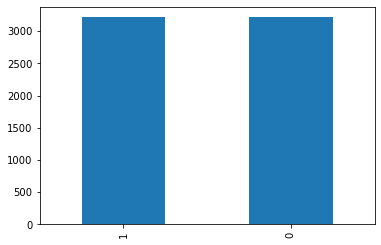

In [118]:
df_new["Sentiment"].value_counts().plot(kind='bar')

There is a class balance present in the data.

### CountVectorizer

In [119]:
from sklearn.feature_extraction.text import CountVectorizer

In [120]:
count_vect = CountVectorizer(max_features=500)
data_features = count_vect.fit_transform(df_new['Review'])
data_features = data_features.toarray()



In [121]:
data_features.shape


(6428, 500)

In [122]:
print(count_vect.get_feature_names())

['able', 'absolutely', 'ac', 'access', 'activities', 'actually', 'add', 'afternoon', 'air', 'airport', 'allow', 'amaze', 'american', 'appear', 'area', 'areas', 'arrival', 'arrive', 'ask', 'available', 'average', 'avoid', 'away', 'awesome', 'bad', 'bag', 'balcony', 'bar', 'base', 'bath', 'bathroom', 'bathrooms', 'bavaro', 'beach', 'beautiful', 'bed', 'believe', 'best', 'better', 'big', 'bite', 'block', 'boat', 'book', 'bother', 'bottle', 'break', 'breakfast', 'bring', 'buffet', 'bug', 'build', 'bus', 'business', 'busy', 'buy', 'ca', 'call', 'cana', 'car', 'card', 'care', 'carpet', 'casino', 'center', 'central', 'certainly', 'chair', 'change', 'charge', 'charm', 'cheap', 'check', 'checkin', 'cheese', 'children', 'choice', 'choose', 'city', 'clean', 'close', 'club', 'coffee', 'cold', 'come', 'comfortable', 'comment', 'complain', 'completely', 'complimentary', 'concierge', 'condition', 'consider', 'convenient', 'cool', 'corner', 'cost', 'country', 'couple', 'course', 'credit', 'crowd', 'cu

In [124]:
print(data_features)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [125]:
X = data_features
y = df_new['Sentiment']

In [126]:
print(X.shape)
print(y.shape)


(6428, 500)
(6428,)


In [127]:
### splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

In [128]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(5142, 500)
(1286, 500)
(5142,)
(1286,)


In [129]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [134]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    print(type(clf))
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    print(scores)
    cv_scores.append(scores.mean())
cv_scores

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.9154519  0.92419825 0.92023346 0.90466926 0.90661479]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.91836735 0.93197279 0.92217899 0.90661479 0.90661479]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.92322643 0.92419825 0.93093385 0.91634241 0.90758755]


[0.9142335311000442, 0.9171497392731413, 0.92045769947779]

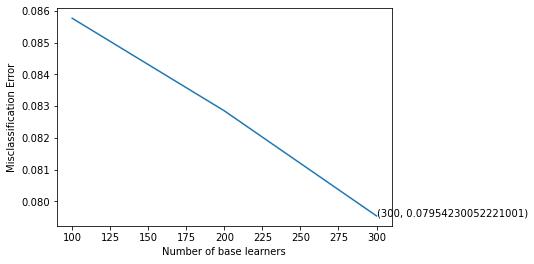

In [135]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [140]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
count_vectorizer_predicted = clf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['1' , '0']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

           1       0.92      0.90      0.91       651
           0       0.90      0.92      0.91       635

    accuracy                           0.91      1286
   macro avg       0.91      0.91      0.91      1286
weighted avg       0.91      0.91      0.91      1286

Accuracy of the model is :  0.9074650077760498


great,wonderful,love,excellent,room,tell,perfect,dirty,comfortable,worst,friendly,helpful,pay,rude,fantastic,bad,staff,terrible,ok,smell,charge,best,location,horrible,poor,highly,wall,disappoint,amaze,fabulous,recommend,hotel,nt,enjoy,spacious,toilet,star,stay,definitely,tiny,
 
 


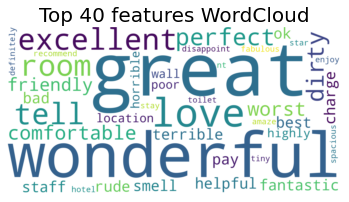

In [141]:
all_features = count_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

#### TfIdf vectorizer


In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [143]:
tfidf_vect = TfidfVectorizer(max_features=500)
data_features = tfidf_vect.fit_transform(df_new['Review'])
data_features = data_features.toarray()
data_features.shape

(6428, 500)

In [151]:
print(tfidf_vect.get_feature_names())

['able', 'absolutely', 'ac', 'access', 'activities', 'actually', 'add', 'afternoon', 'air', 'airport', 'allow', 'amaze', 'american', 'appear', 'area', 'areas', 'arrival', 'arrive', 'ask', 'available', 'average', 'avoid', 'away', 'awesome', 'bad', 'bag', 'balcony', 'bar', 'base', 'bath', 'bathroom', 'bathrooms', 'bavaro', 'beach', 'beautiful', 'bed', 'believe', 'best', 'better', 'big', 'bite', 'block', 'boat', 'book', 'bother', 'bottle', 'break', 'breakfast', 'bring', 'buffet', 'bug', 'build', 'bus', 'business', 'busy', 'buy', 'ca', 'call', 'cana', 'car', 'card', 'care', 'carpet', 'casino', 'center', 'central', 'certainly', 'chair', 'change', 'charge', 'charm', 'cheap', 'check', 'checkin', 'cheese', 'children', 'choice', 'choose', 'city', 'clean', 'close', 'club', 'coffee', 'cold', 'come', 'comfortable', 'comment', 'complain', 'completely', 'complimentary', 'concierge', 'condition', 'consider', 'convenient', 'cool', 'corner', 'cost', 'country', 'couple', 'course', 'credit', 'crowd', 'cu

In [145]:
print(data_features)

[[0.         0.         0.         ... 0.18160863 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [146]:
X = data_features
y = df_new['Sentiment']


In [147]:
### splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

In [149]:
print("X_train size:",X_train.shape)
print("X_test size:",X_test.shape)
print("y_train size:",y_train.shape)
print("y_test size:",y_test.shape)


X_train size: (5142, 500)
X_test size: (1286, 500)
y_train size: (5142,)
y_test size: (1286,)


In [150]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [156]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    print(scores)
    cv_scores.append(scores.mean())
cv_scores

[0.91836735 0.92031098 0.92120623 0.90953307 0.90272374]
[0.91739553 0.92905734 0.92509728 0.89980545 0.91536965]
[0.92322643 0.93391642 0.92412451 0.9114786  0.91536965]


[0.9144282726987404, 0.9173450480803773, 0.9216231239577543]

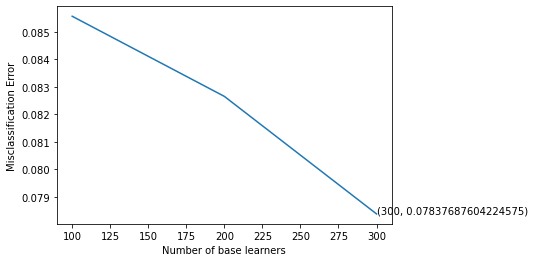

In [160]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [159]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
tf_idf_predicted = clf.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names = ['0' , '1']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       651
           1       0.89      0.93      0.91       635

    accuracy                           0.91      1286
   macro avg       0.91      0.91      0.91      1286
weighted avg       0.91      0.91      0.91      1286

Accuracy of the model is :  0.9082426127527217


[[580  71]
 [ 47 588]]


<AxesSubplot:>

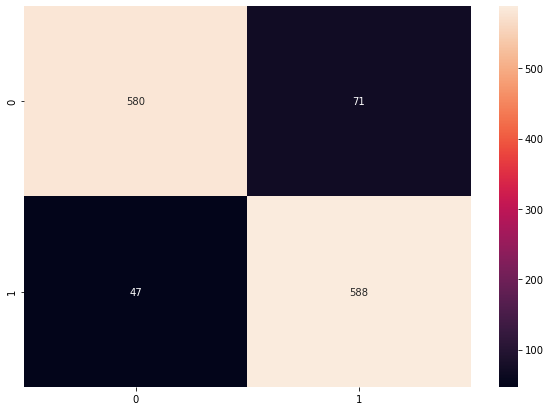

In [161]:

conf_mat = confusion_matrix(y_test, tf_idf_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['0', '1']],
                  columns = [i for i in ['0', '1']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

great, love, excellent, wonderful, room, tell, helpful, worst, friendly, perfect, comfortable, dirty, fantastic, pay, bad, rude, best, staff, terrible, location, ok, enjoy, highly, charge, recommend, smell, horrible, poor, fabulous, amaze, wall, disappoint, walk, hotel, spacious, stay, definitely, tiny, nt, night, 
 
 


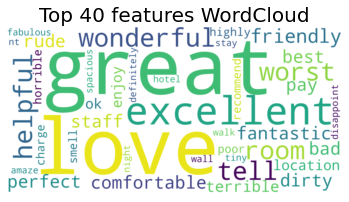

In [162]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '
    
print(top_features)  

print(" ") 
print(" ") 

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

In [163]:
#convert the test samples into a dataframe where the columns are
#the y_test(ground truth labels),tf-idf model predicted labels(tf_idf_predicted),Count Vectorizer model predicted labels(count_vectorizer_predicted)
df = pd.DataFrame(y_test.tolist(),columns =['y_test'])
df['count_vectorizer_predicted'] = count_vectorizer_predicted
df['tf_idf_predicted'] = tf_idf_predicted
df.head()

,y_test,count_vectorizer_predicted,tf_idf_predicted
0,0,0,0
1,0,0,0
2,1,1,1
3,1,0,0
4,0,0,0


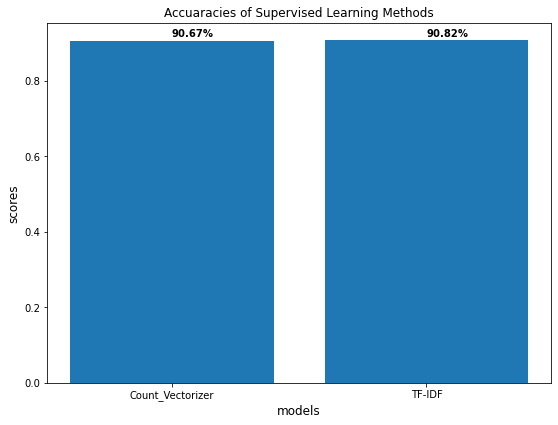

In [164]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TF-IDF']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test,count_vectorizer_predicted),accuracy_score(y_test,tf_idf_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies of Supervised Learning Methods')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

TFIDF performs better than CountVectorizer